In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from monai.transforms import Compose, ScaleIntensity, EnsureChannelFirst, ToTensor, Rotate90
from dataloader import CTScanData
from vit_model import VisionTransformer3D, UpsampleAttentionMap
import random
import nibabel as nib

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Function to remove 'module.' prefix from state_dict keys
def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [8]:
# Load model
in_channels = 1
d_model = 256
feedforward_dim = 512
num_heads = 8
patch_size = 16
num_layers = 8
num_classes = 2

model = VisionTransformer3D(in_channels, d_model, feedforward_dim, patch_size, num_classes=num_classes, num_layers=num_layers)
state_dict = torch.load('./Data/results_2/epoch_430_model.pt')
state_dict = remove_module_prefix(state_dict)  # Remove 'module.' prefix
model.load_state_dict(state_dict)
model.to(device)
model.eval()

VisionTransformer3D(
  (patch_embedding): PatchEmbedding3D(
    (proj): Conv3d(1, 256, kernel_size=(16, 16, 16), stride=(16, 16, 16))
  )
  (transformerlayers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (attention_layer): Attention(
        (qkv_layer): Linear(in_features=256, out_features=768, bias=False)
        (dropout_layer): Dropout(p=0.0, inplace=False)
        (softmax_layer): Softmax(dim=-1)
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (linear_layer): Linear(in_features=256, out_features=256, bias=True)
      )
      (feedforward_layer): FeedForward(
        (net): Sequential(
          (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (1): Linear(in_features=256, out_features=512, bias=True)
          (2): GELU(approximate='none')
          (3): Dropout(p=0.0, inplace=False)
          (4): Linear(in_features=512, out_features=256, bias=True)
          (5): Dropout(p=0.0, inplace=False)
        )
      )
    )


In [9]:

# Load attention map
attn_map_path = './Data/view_attn_maps/final_attention_map.nii.gz'
attn_map = nib.load(attn_map_path).get_fdata()
attn_map.shape

(224, 224, 224)

In [10]:
class0_path = './Data/view_attn_maps/image_class0_id28_age58.nii.gz'
img_class0 = nib.load(class0_path).get_fdata()
img_class0.shape

(224, 224, 224)

In [11]:
class1_path = './Data/view_attn_maps/image_class1_id24_age77.nii.gz'
img_class1 = nib.load(class1_path).get_fdata()
img_class1.shape

(224, 224, 224)

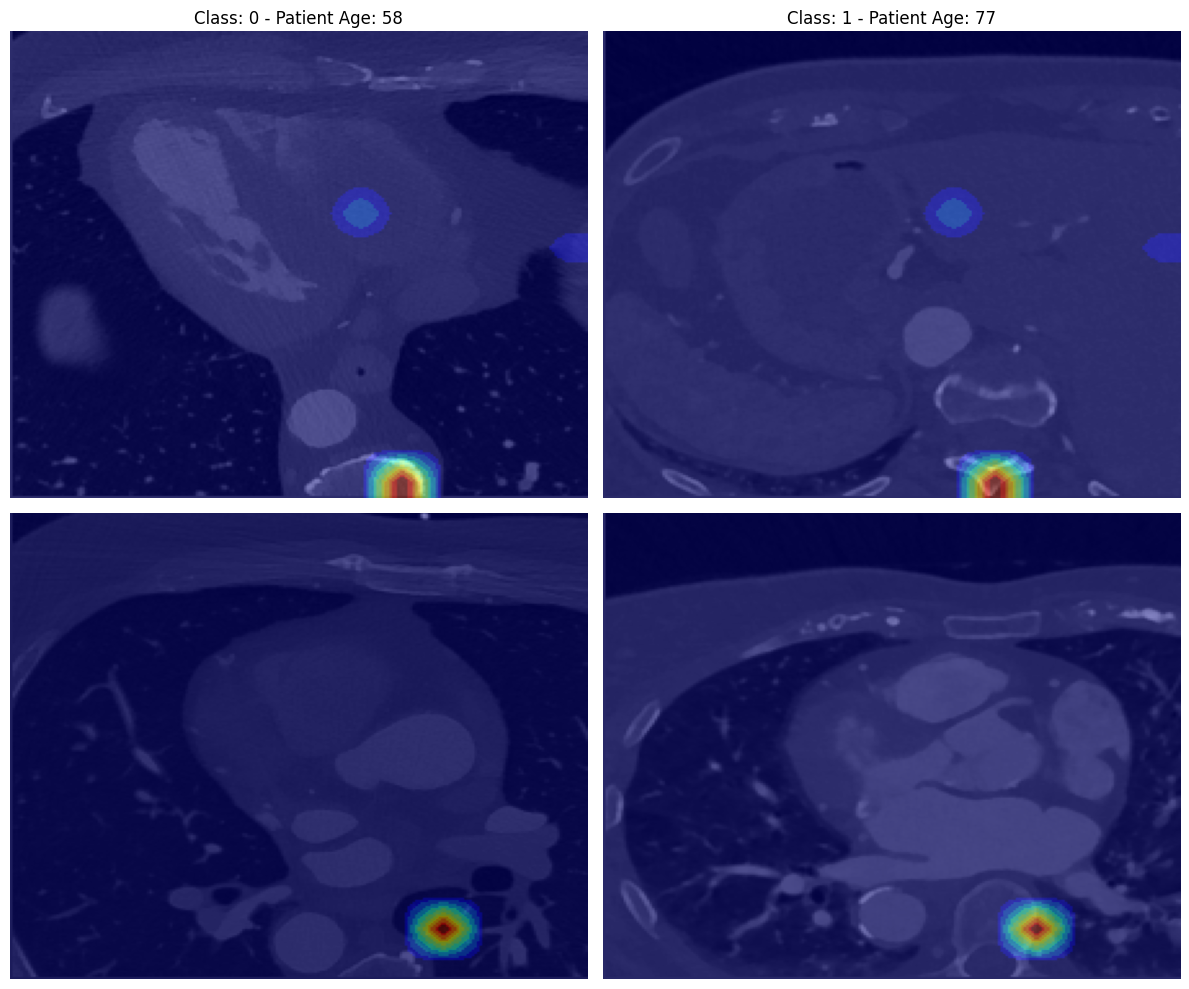

In [22]:
layer1 = 56
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].imshow(np.rot90(img_class0[:,:,layer1], k=3), cmap='gray', aspect='auto')
ax[0,0].set_title(f'Class: 0 - Patient Age: 58')
ax[0,0].axis('off')
ax[0,0].imshow(np.rot90(attn_map[:,:,layer1], k=3), cmap='jet', aspect='auto',alpha=0.5)

ax[0,1].imshow(np.rot90(img_class1[:,:,layer1], k=3), cmap='gray', aspect='auto')
ax[0,1].set_title(f'Class: 1 - Patient Age: 77')
ax[0,1].imshow(np.rot90(attn_map[:,:,layer1], k=3), cmap='jet', aspect='auto',alpha=0.5)
ax[0,1].axis('off')

layer2 = 167
ax[1,0].imshow(np.rot90(img_class0[:,:,layer2], k=3), cmap='gray', aspect='auto')
# ax[1,0].set_title(f'Class: 0 - Patient Age: 58')
ax[1,0].axis('off')
ax[1,0].imshow(np.rot90(attn_map[:,:,layer2], k=3), cmap='jet', aspect='auto',alpha=0.5)

ax[1,1].imshow(np.rot90(img_class1[:,:,layer2], k=3), cmap='gray', aspect='auto')
# ax[1,1].set_title(f'Class: 1 - Patient Age: 77')
ax[1,1].imshow(np.rot90(attn_map[:,:,layer2], k=3), cmap='jet', aspect='auto',alpha=0.5)
ax[1,1].axis('off')

fig.tight_layout()
plt.show()


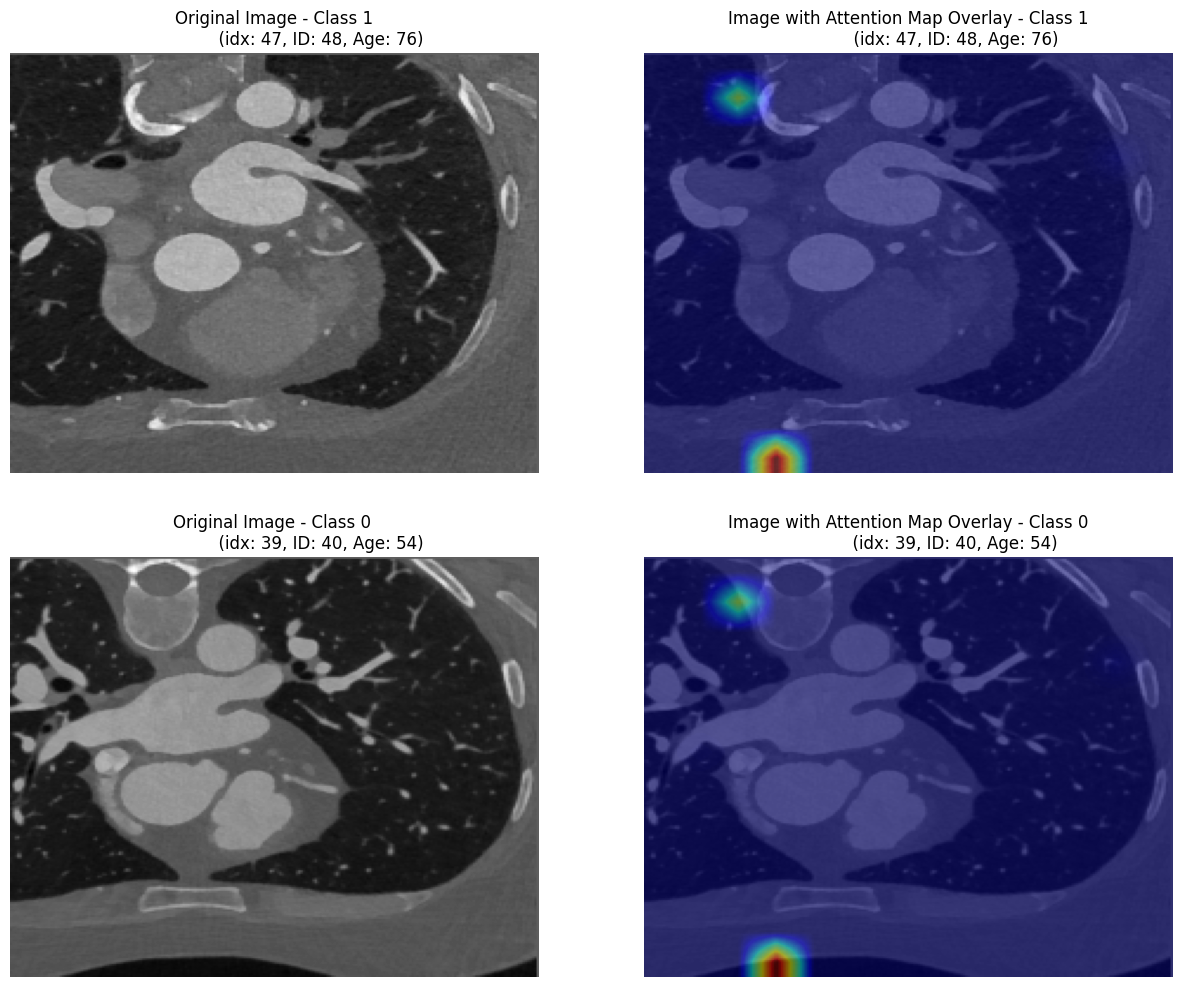

In [29]:

# Plot the original image and attention map overlay
layer = 183 #56
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
ax[0,0].imshow(image_class1.cpu().numpy().squeeze()[:,:,layer], cmap='gray', aspect='auto')
ax[0,0].set_title(f'''Original Image - Class 1
                  (idx: {idx_class1}, ID: {df['ID'][idx_class1]}, Age: {df['Age'][idx_class1]})''')
ax[0,0].axis('off')

ax[0,1].imshow(image_class1.cpu().numpy().squeeze()[:,:,layer], cmap='gray', aspect='auto')
ax[0,1].imshow(attention_map_2d_normalized[:,:,layer], cmap='jet', aspect='auto',
               alpha=0.5)#*(attention_map_2d_normalized[:,:,layer]<0.005))
ax[0,1].set_title(f'''Image with Attention Map Overlay - Class 1
                  (idx: {idx_class1}, ID: {df['ID'][idx_class1]}, Age: {df['Age'][idx_class1]})''')
ax[0,1].axis('off')

ax[1,0].imshow(image_class0.cpu().numpy().squeeze()[:,:,layer], cmap='gray', aspect='auto')
ax[1,0].set_title(f'''Original Image - Class 0 
                  (idx: {idx_class0}, ID: {df['ID'][idx_class0]}, Age: {df['Age'][idx_class0]})''')
ax[1,0].axis('off')

ax[1,1].imshow(image_class0.cpu().numpy().squeeze()[:,:,layer], cmap='gray', aspect='auto')
ax[1,1].imshow(attention_map_2d_normalized[:,:,layer], cmap='jet', aspect='auto',
               alpha=0.5)#*(attention_map_2d_normalized[:,:,layer]<0.005))
ax[1,1].set_title(f'''Image with Attention Map Overlay - Class 0
                  (idx: {idx_class0}, ID: {df['ID'][idx_class0]}, Age: {df['Age'][idx_class0]})''')
ax[1,1].axis('off')
# plt.subplots_adjust(wspace=0)
plt.show()


(array([1.1152222e+07, 4.6246000e+04, 1.8368000e+04, 9.3600000e+03,
        5.6080000e+03, 3.3120000e+03, 1.9760000e+03, 1.1720000e+03,
        7.9200000e+02, 3.6800000e+02]),
 array([5.47131297e-16, 1.17309568e-02, 2.34619137e-02, 3.51928696e-02,
        4.69238274e-02, 5.86547852e-02, 7.03857392e-02, 8.21167007e-02,
        9.38476548e-02, 1.05578616e-01, 1.17309570e-01]),
 <BarContainer object of 10 artists>)

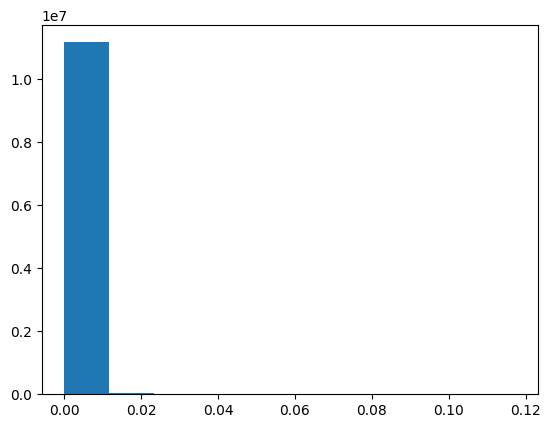

In [31]:
plt.hist(attention_map_2d.flatten())

In [39]:
np.max(attention_map_2d), np.min(attention_map_2d)

(0.11730957, 5.471313e-16)

In [38]:
attention_map_2d[np.where(attention_map_2d>.11)]

array([0.11352658, 0.11352658, 0.11352658, 0.11352658, 0.11352658,
       0.11352658, 0.11352658, 0.11352658, 0.11364365, 0.11364365,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11730957,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11730957,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11730957,
       0.11730957, 0.11364365, 0.11364365, 0.11730957, 0.11730957,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11730957,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11730957,
       0.11730957, 0.11730957, 0.11730957, 0.11730957, 0.11729193,
       0.11729193, 0.11729193, 0.11729193, 0.11729193, 0.11729193,
       0.11729193, 0.11729193, 0.11362656, 0.11729193, 0.11729193,
       0.11729193, 0.11729193, 0.11729193, 0.11729193, 0.11729193,
       0.11729193, 0.11362656, 0.1172934 , 0.1172934 , 0.1172934 ,
       0.1172934 , 0.1172934 , 0.1172934 , 0.1172934 , 0.1172934 ,
       0.11362798, 0.1172934 , 0.1172934 , 0.1172934 , 0.11729

In [40]:
np.argwhere(attention_map_2d >.11)

array([[ 55, 199, 167],
       [ 55, 199, 168],
       [ 55, 200, 167],
       [ 55, 200, 168],
       [ 56, 199, 167],
       [ 56, 199, 168],
       [ 56, 200, 167],
       [ 56, 200, 168],
       [ 71, 215,  55],
       [ 71, 215,  56],
       [ 71, 216,  55],
       [ 71, 216,  56],
       [ 71, 217,  55],
       [ 71, 217,  56],
       [ 71, 218,  55],
       [ 71, 218,  56],
       [ 71, 219,  55],
       [ 71, 219,  56],
       [ 71, 220,  55],
       [ 71, 220,  56],
       [ 71, 221,  55],
       [ 71, 221,  56],
       [ 71, 222,  55],
       [ 71, 222,  56],
       [ 71, 223,  55],
       [ 71, 223,  56],
       [ 72, 215,  55],
       [ 72, 215,  56],
       [ 72, 216,  55],
       [ 72, 216,  56],
       [ 72, 217,  55],
       [ 72, 217,  56],
       [ 72, 218,  55],
       [ 72, 218,  56],
       [ 72, 219,  55],
       [ 72, 219,  56],
       [ 72, 220,  55],
       [ 72, 220,  56],
       [ 72, 221,  55],
       [ 72, 221,  56],
       [ 72, 222,  55],
       [ 72, 222

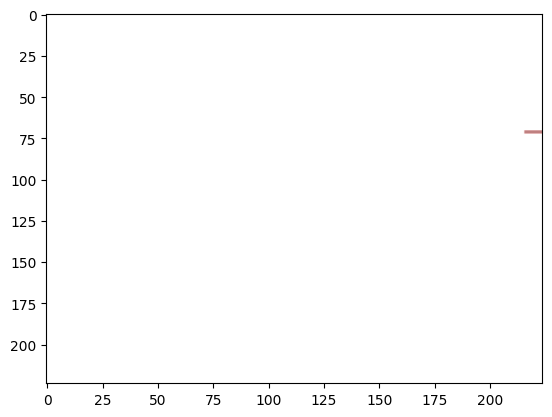

In [23]:
plt.imshow(attention_map_2d_normalized[:,:,55], cmap='jet', aspect='auto',
               alpha=0.5*(attention_map_2d_normalized[:,:,55]==1.0))

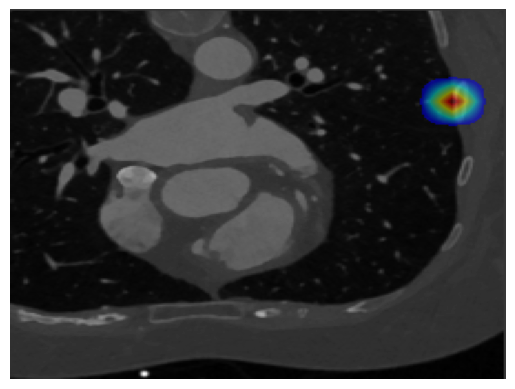

In [45]:

# Plot the original image and attention map overlay
layer = 167

plt.imshow(image_class1.cpu().numpy().squeeze()[:,:,layer], cmap='gray', aspect='auto')
plt.imshow(attention_map_2d[:,:,layer], cmap='jet', aspect='auto',
               alpha=0.5*(attention_map_2d[:,:,layer]>0.01))
plt.axis('off')

plt.show()


In [69]:
import nibabel as nib
img_load = nib.load("./Data/Resampled/1_resampled_img.nii.gz")
attn_map_nii = nib.Nifti1Image((attention_map_2d_normalized > 0.5 ).astype(np.uint8).T, img_load.affine)
nib.save(attn_map_nii, './Data/results_2/attention_map.nii.gz')

In [29]:
np.max(img_load.affine), np.min(img_load.affine)

(313.2892761230469, -1224.2969970703125)

In [71]:
len(np.unique(attention_map_2d_normalized))

8803240

In [73]:
np.quantile(attention_map_2d_normalized, [0.25,0.5, 0.75, 0.95, 0.99])

array([4.13874774e-08, 7.29907129e-07, 2.26170378e-05, 4.40748066e-03,
       7.68215435e-02])

In [76]:
len(np.unique((attention_map_2d_normalized[attention_map_2d_normalized > 0.5])))

908

In [104]:
final_attn_map = attention_map_2d_normalized.copy()
final_attn_map.shape

(224, 224, 224)

In [105]:
# final_attn_map[np.where(final_attn_map < 0.5)] = 0.

In [106]:
final_attn_map.shape

(224, 224, 224)

In [107]:
map_ints = {0.5: 0,0.6: 1, 0.7: 2, 0.8: 3, 0.9: 4, 1.0: 5}

In [108]:
def map_values(value):
    if value < 0.05:
        return 0
    elif value < 0.1:
        return 1
    elif value < 0.2:
        return 2
    elif value < 0.3:
        return 3
    elif value < 0.4:
        return 4
    elif value < 0.5:
        return 5
    elif value < 0.6:
        return 6
    elif value < 0.7:
        return 7
    elif value < 0.8:
        return 8
    elif value < 0.9:
        return 9
    elif value <= 1.0:
        return 10
    else:
        return -1  # For values outside the expected range


In [109]:
vectorized_map_values = np.vectorize(map_values)
cc = vectorized_map_values(final_attn_map)

In [110]:
np.unique(cc)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [111]:
attn_map_nii = nib.Nifti1Image(cc.T, img_load.affine)
nib.save(attn_map_nii, './Data/results_2/final_attention_map.nii.gz')

In [68]:
# image_class1_nii = nib.Nifti1Image(image_class1.cpu().numpy().squeeze(), img_load.affine)
# nib.save(image_class1_nii, 'image_class1.nii.gz')